## Cross Neutralizing

In [1]:
TASK = "POS"

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

sns.set_style("white")
sns.set_context("paper", font_scale=2)

In [3]:
TAG_REGEX = r".*\/evaluation_(\w+)\/.*"
EXPERIMENT_REGEX = r".*\/(.+=.+)\/.*"

def get_base_series(path):
    if "*" in path:
        path = glob.glob(path)[0]

    ea = EventAccumulator(path)
    ea.Reload()

    scalars = {}
    for metric in ea.Tags()["scalars"]:
        if "test" not in metric:
            continue

        scalar = ea.Scalars(metric)[0].value

        parts = metric.split("_")
        if len(parts) == 2:
            tag = "average"
        else:
            tag = parts[-1].upper()

        scalars[tag] = scalar

    return pd.Series(scalars)

def get_xn_df(glob_path):
    neutralizers = {}
    for path in glob.glob(glob_path):
        res = re.search(TAG_REGEX, path)
        base_tag = res.group(1).upper()

        ea = EventAccumulator(path)
        ea.Reload()

        scalars = {}
        for metric in ea.Tags()["scalars"]:
            if "test" not in metric:
                continue

            scalar = ea.Scalars(metric)[0].value

            if "/" not in metric:
                tag = "average"
            else:
                tag = metric.split("_")[-1].upper()

            scalars[tag] = scalar

        neutralizers[base_tag] = scalars

    df = pd.DataFrame(neutralizers)
    df.index.name = "Target"
    df = df.T
    df.index.name = "Neutralizer"
    return df

def get_acc_drop(eval_path):
    base_series = get_base_series(f"{eval_path}/events*")
    xn_df = get_xn_df(f"{eval_path}_*/events*")

    nulls = base_series.isnull()
    base_series = base_series[~nulls]
    xn_df = xn_df.T[~nulls].T

    acc_drop = xn_df - base_series
    acc_drop.sort_index(axis=0, inplace=True)
    acc_drop.sort_index(axis=1, inplace=True)
    return acc_drop

def get_experiments_df(task):
    experiments = {}
    for path in glob.glob(f"../lightning_logs/roberta-base/en_gum/{task}/*/evaluation"):
        res = re.search(EXPERIMENT_REGEX, path)
        experiment = res.group(1)
        acc_drop = get_acc_drop(path)

        self_neutr = {}
        for tag in acc_drop.columns.values[:-1]:
            tag = tag.upper()
            self_neutr[tag] = acc_drop[tag][tag]

        self_neutr["average"] = np.nanmean(list(self_neutr.values()))
        experiments[experiment] = self_neutr

    df = pd.DataFrame(experiments)
    df.sort_values(by="average", axis=1, inplace=True)

    nulls = df.isnull().all(1)
    df = df[~nulls]

    df.index.name = "Neutralizer"
    df = df.T
    df.index.name = "Experiment"
    return df

def plot_heatmap(df, save_name=None):
    plt.figure(figsize=(20, 20), dpi=300)
    sns.heatmap(df, annot=True, fmt=".2f")

    if save_name:
        plt.savefig(save_name)

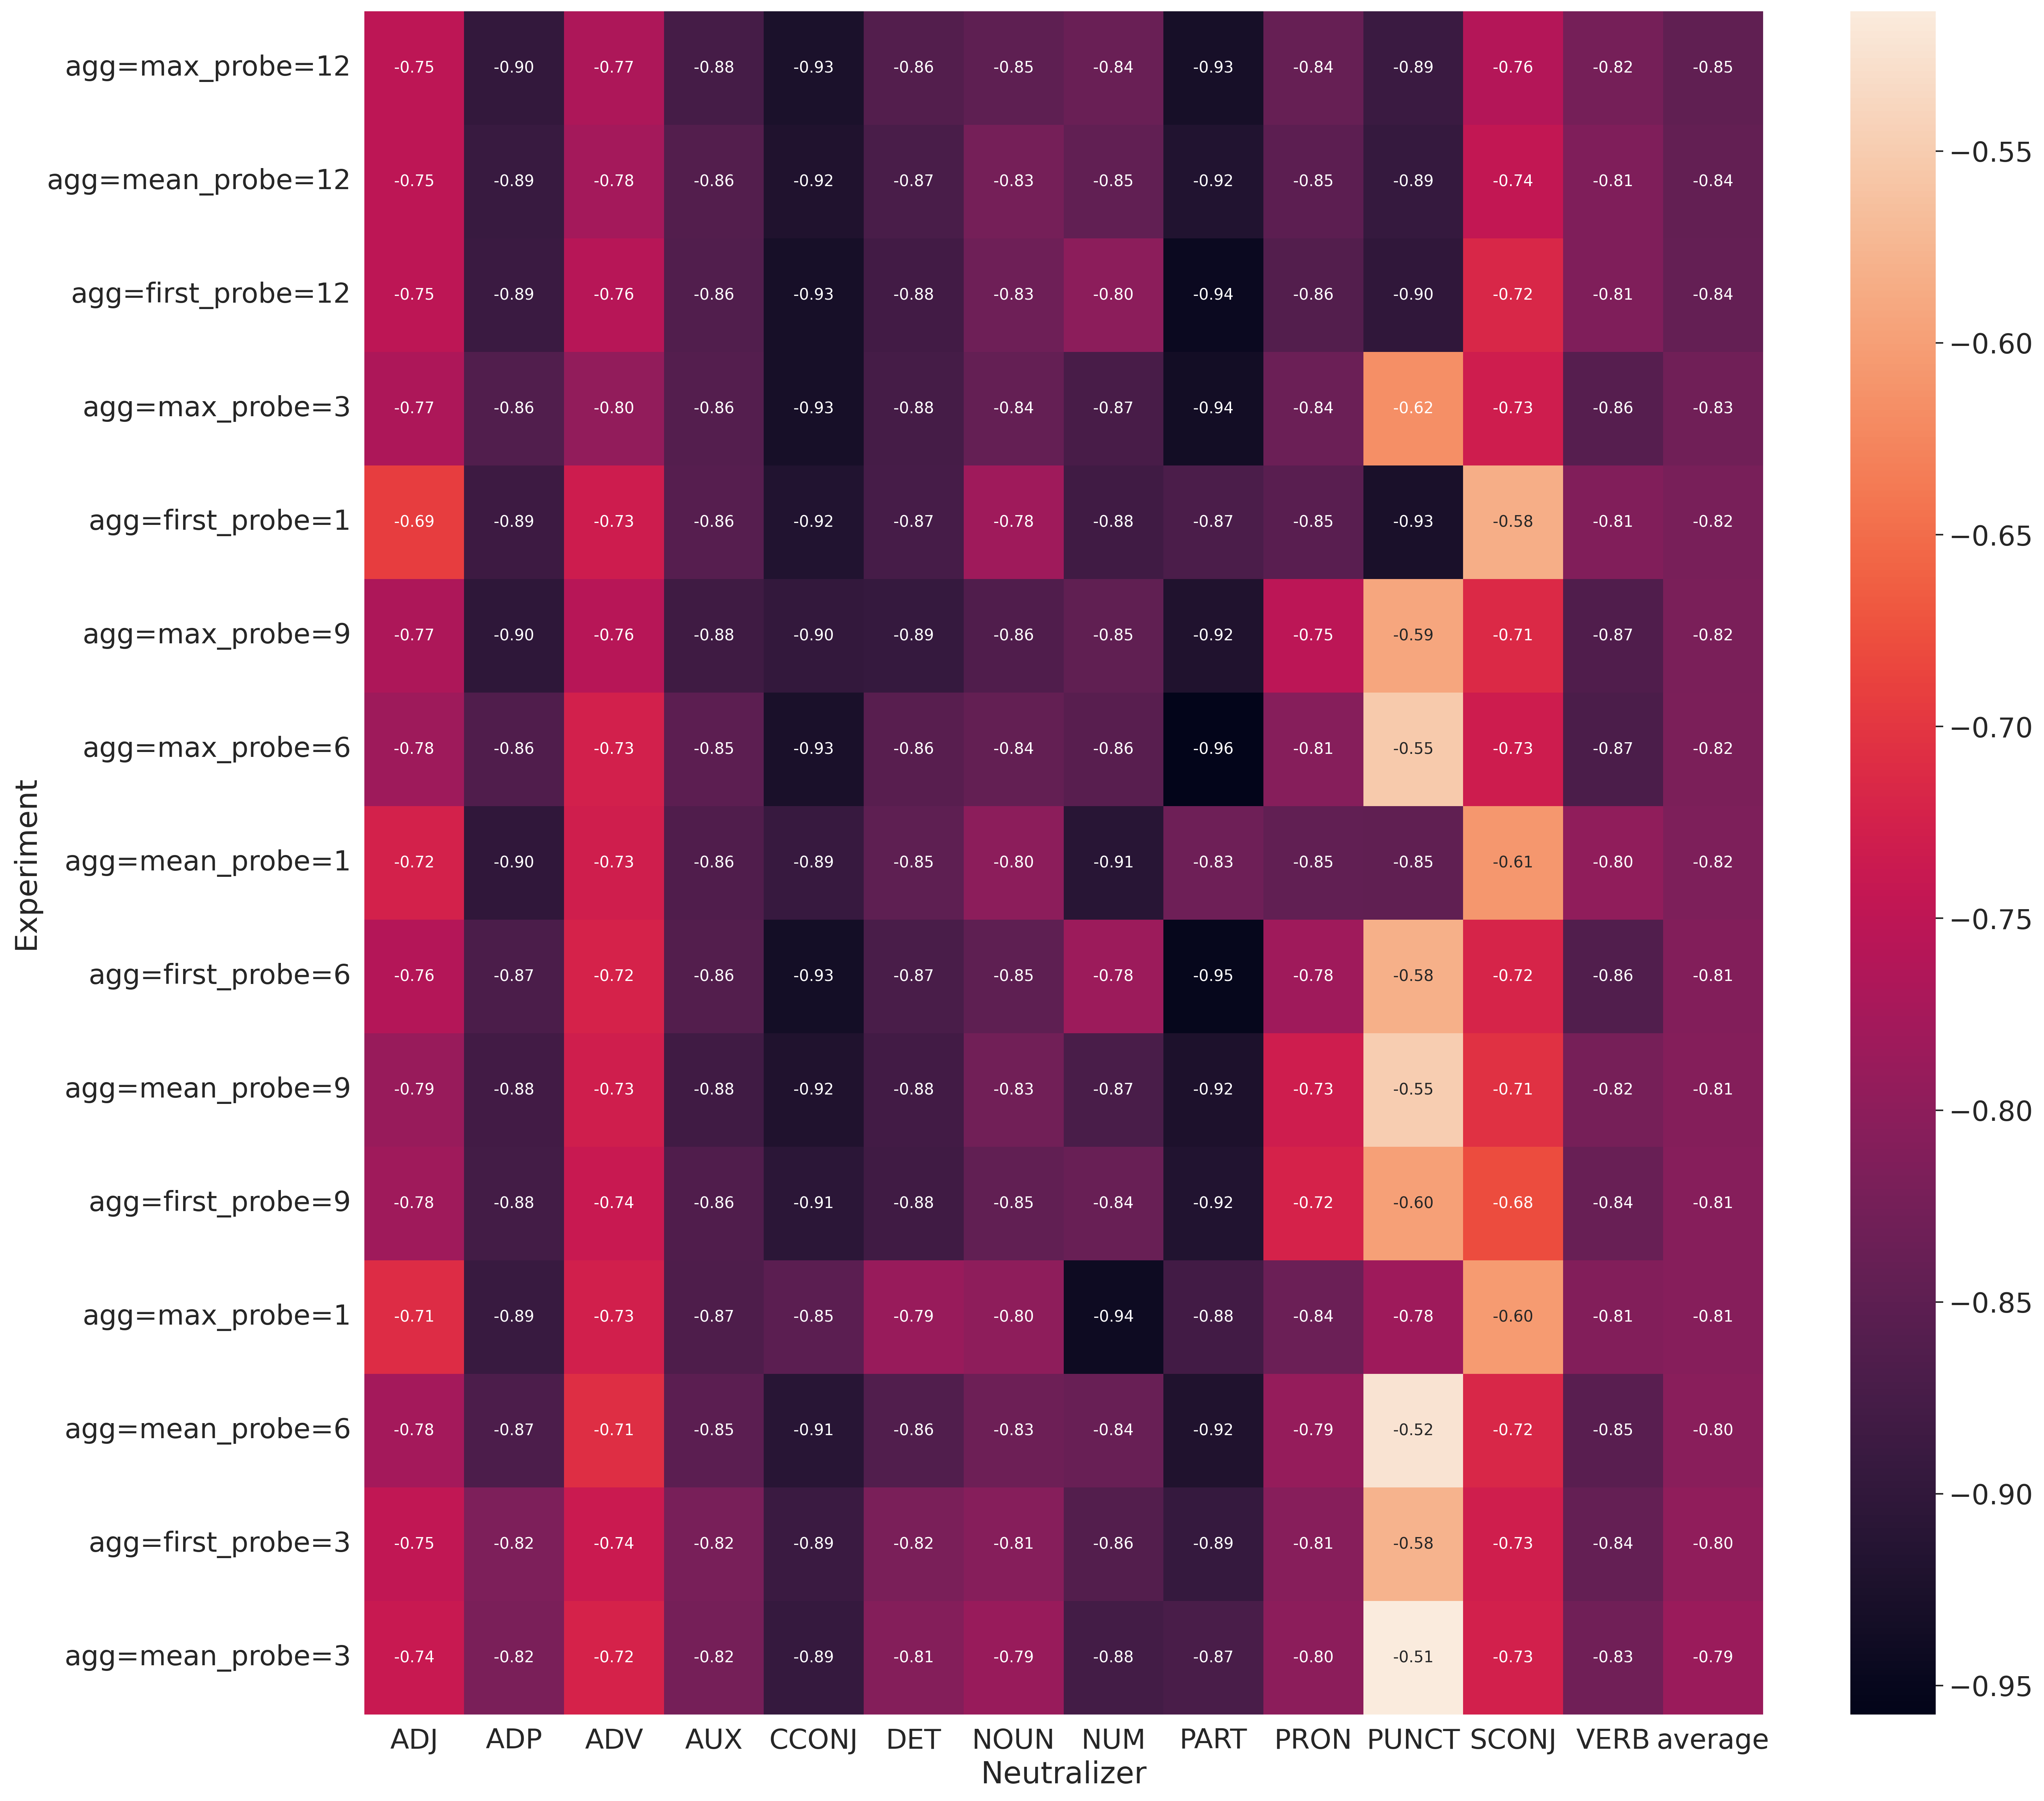

In [4]:
plot_heatmap(get_experiments_df(TASK), save_name=f"{TASK}_experiments.pdf")

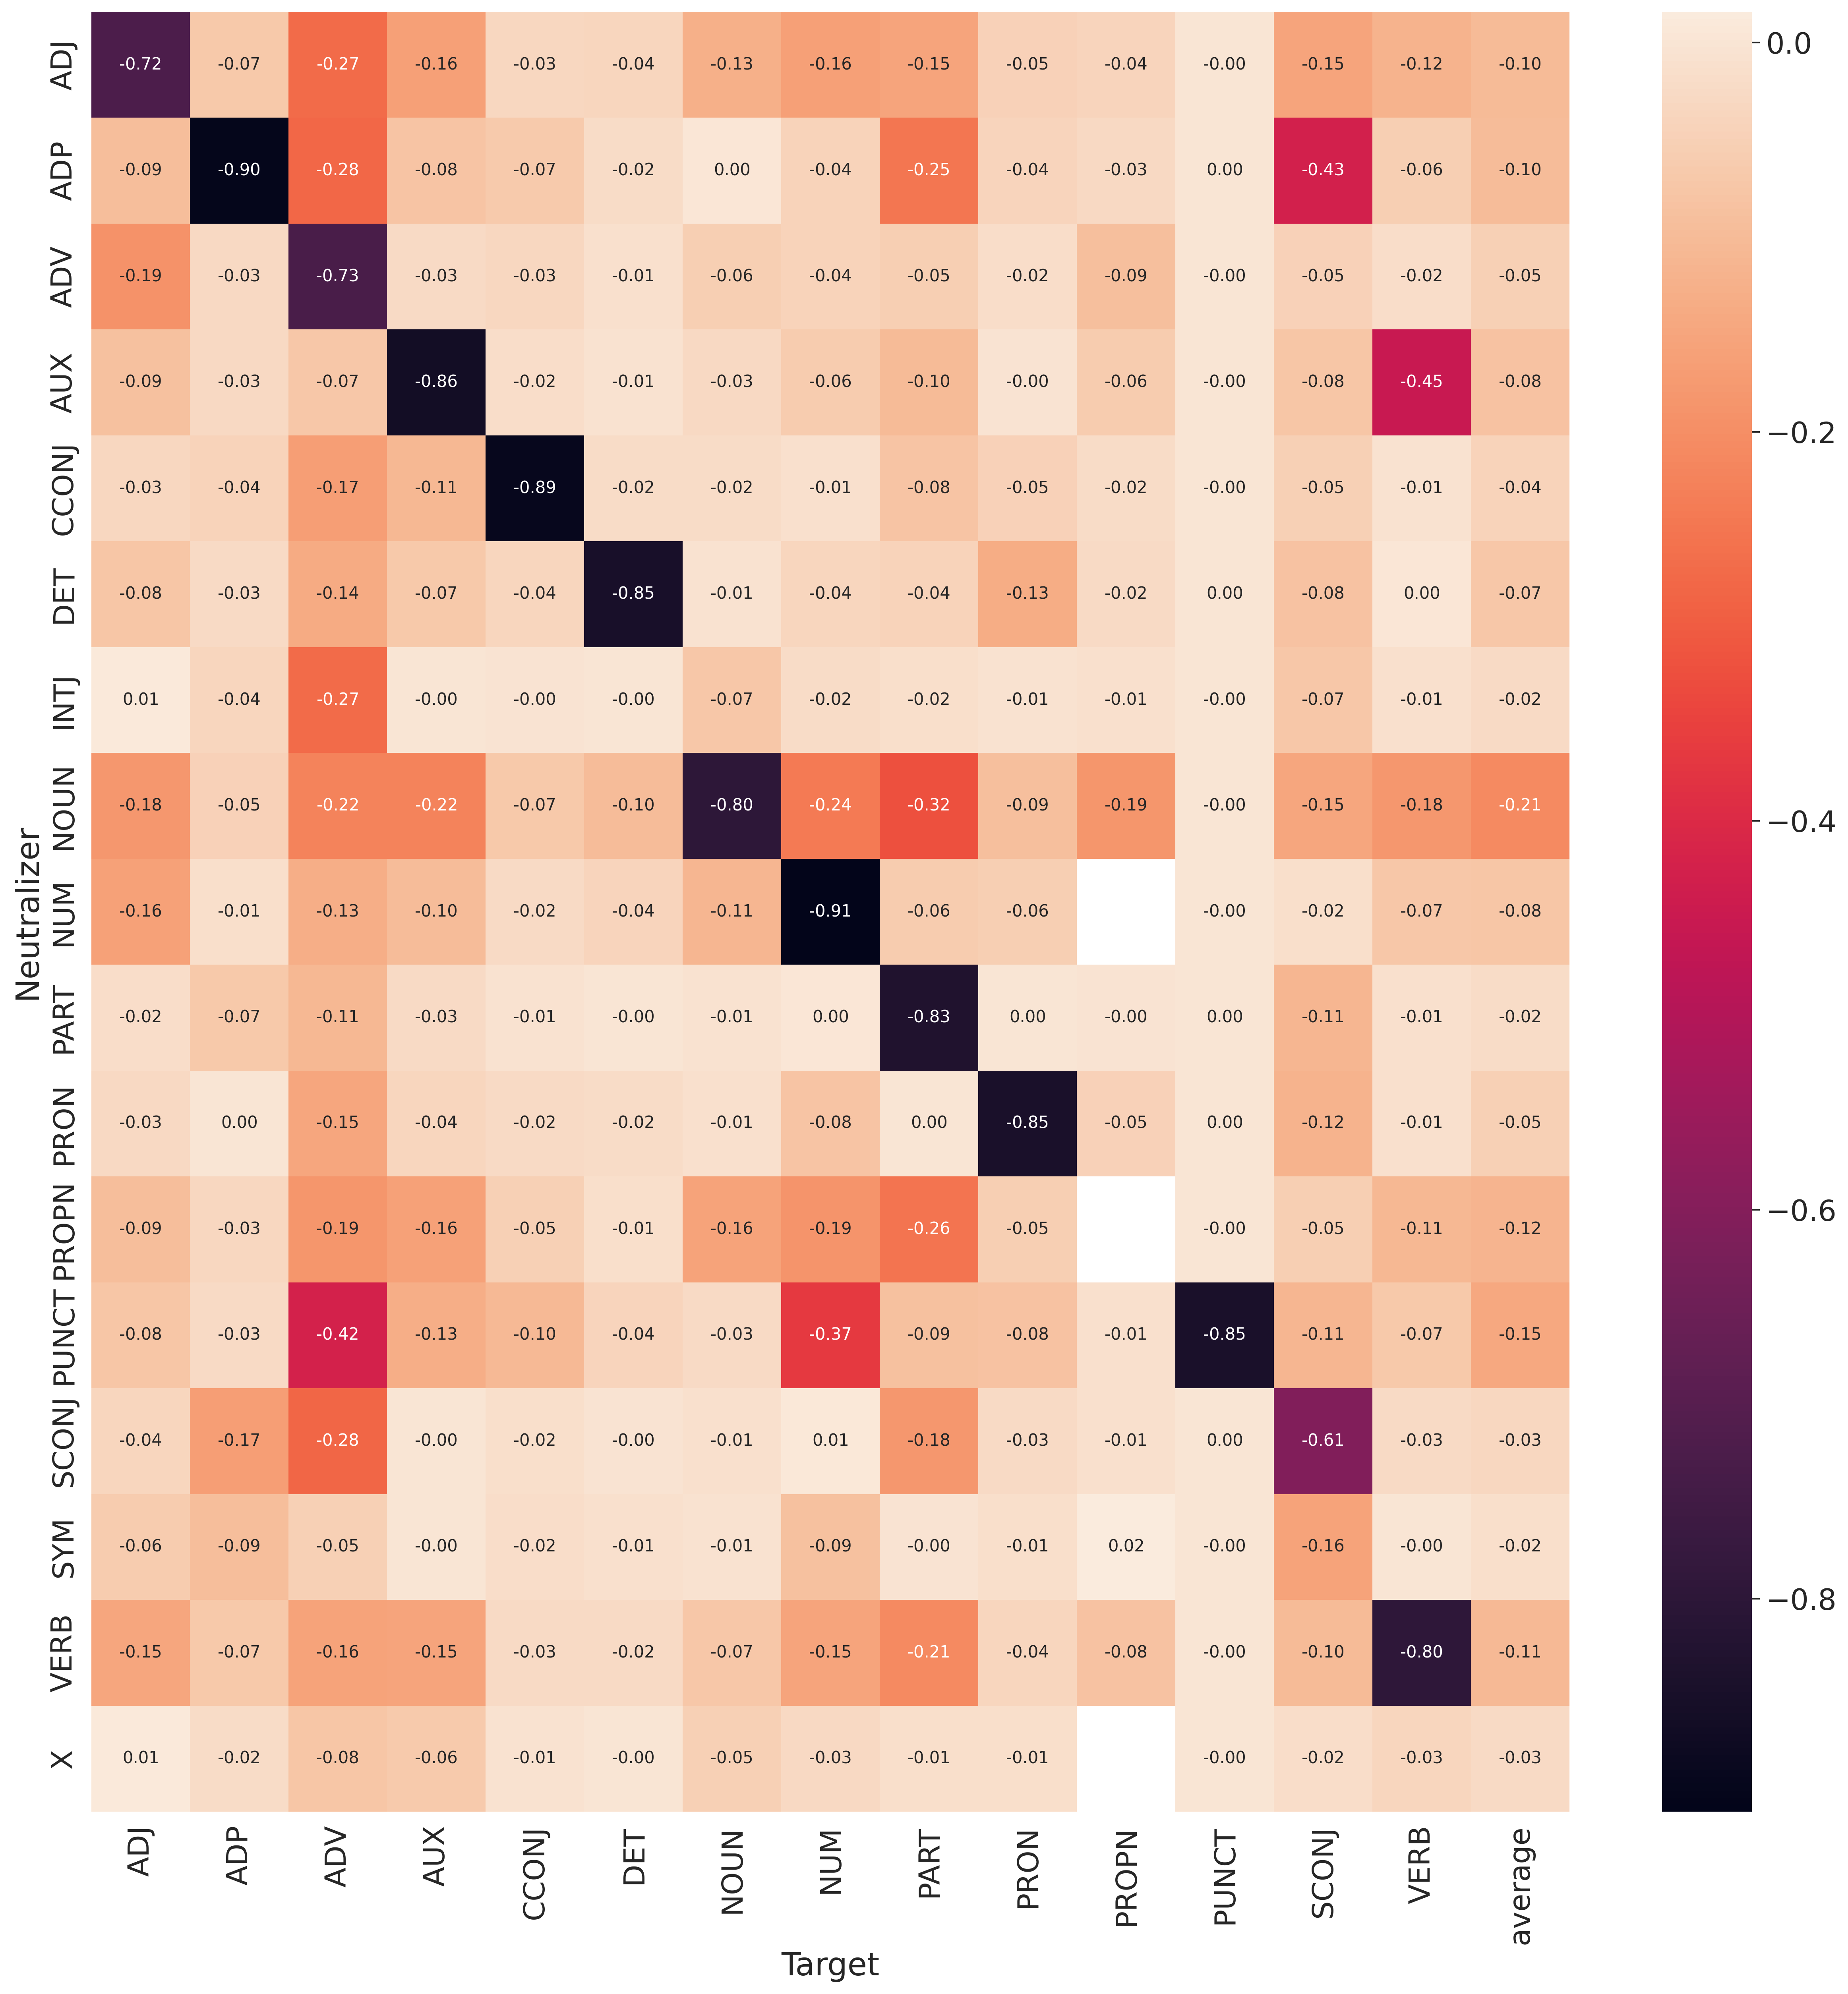

In [5]:
MODEL = "agg=mean_probe=1"

eval_path = f"../lightning_logs/roberta-base/en_gum/{TASK}/{MODEL}/evaluation"
acc_drop = get_acc_drop(eval_path)
plot_heatmap(acc_drop, save_name=f"{TASK}_acc_drop_{MODEL}.pdf")